# Week 9: Support Vector Machines for Regression
------------------------------------------------------
Machine Learning     Year 2020/2021

*Vanessa Gómez Verdejo vanessa@tsc.uc3m.es* and *Pablo M. Olmos olmos@tsc.uc3m.es*

------------------------------------------------------

We now extend support vector machines to regression problems while at the same time preserving the property of sparseness.

A good tutorial about Regression Vector Machines can be found in this [link](https://www.svms.org/regression/SmSc98.pdf)


In [3]:
import time

import numpy as np

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [6,6]

## Kernel Ridge Regression: a review

Given a training set in the feature space $\mathcal{D}=(\phi(\mathbf{x})^{(i)},y^{(i)})$, $i=1,\ldots,N$, where $\mathbf{x}\in\mathbb{R}^D$ and $y^{(i)}\in\mathbb{R}$, Ridge Regression minimizes a regularized version of the mean squared error:

\begin{align}
\sum_{i=1}^{N} \left(y^{(i)}-f(\mathbf{x}^{(i)})\right)^2 + \lambda \sum_{j=1}^{D+1} w_j^2
\end{align}

where $f(\mathbf{x})={\bf w}^T\phi(\mathbf{x}^{(i)})$.

In the last notebook, analyzing its solution, we saw that:
* We could obtain no-linear solutions
* But the regression model was **no sparse**. All training data were used as support of the solution.


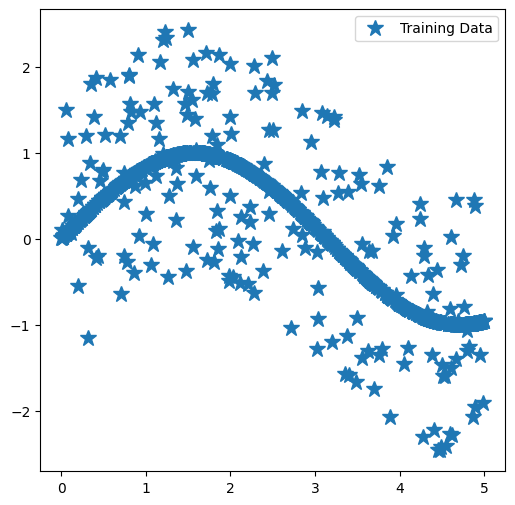

In [4]:
rng = np.random.RandomState(0)

# #############################################################################
# Generate sample data

N_train = 1000

X = 5 * rng.rand(N_train, 1)
y = np.sin(X).ravel()

# Add noise to every 5 targets
y[::5] += 3 * (0.5 - rng.rand(X.shape[0] // 5))

X_plot = np.linspace(0, 5, 100000)[:, None]

plt.plot(X,y,'*',markersize=12)
plt.legend(['Training Data'])
plt.show()

Train Kernel Ridge: 0.090445 seconds
Test Kernel Ridge: 2.585825 seconds
The fraction of training points that participate in the test decision is 100.000000


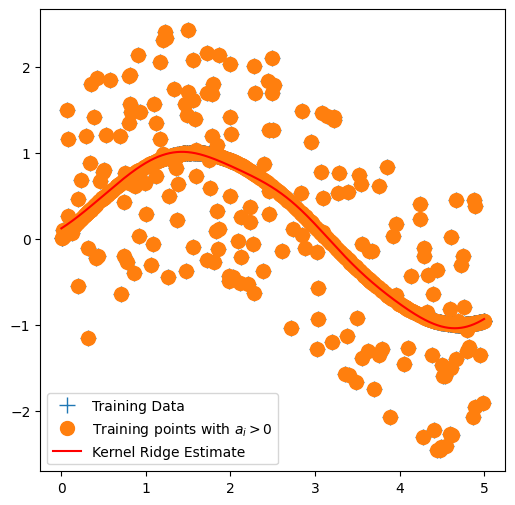

In [5]:
# Train a Kernel Ridge Regression model

KR_model = KernelRidge(kernel='rbf',alpha=1,gamma=1)

t0 = time.time()

KR_model.fit(X,y)

train_time = time.time()-t0

t0 = time.time()

y_plot = KR_model.predict(X_plot)

test_time=time.time()-t0

# Analize the solution and the model performance

print('Train Kernel Ridge: %f seconds' %(train_time))
print('Test Kernel Ridge: %f seconds' %(test_time))

a_coef = KR_model.dual_coef_

plt.figure()
plt.plot(X,y,'+',markersize=12)
plt.plot(X[np.abs(a_coef)>0],y[np.abs(a_coef)>0],'o',markersize=10)
plt.plot(X_plot,y_plot,'r')

plt.legend(['Training Data','Training points with $a_i>0$','Kernel Ridge Estimate',])
print('The fraction of training points that participate in the test decision is %f' %(100*np.sum(np.abs(a_coef)>0)/N_train))


All training data have a no-zero dual variable ($a^{(i)}\neq 0$) and this increases considerably the testing time!!!! Besides, it can create overfitting problems.

## Regression Vector Machines: Sparse Linear Regression

To obtain sparse solutions, Regression Vector Machines replace the quadratic error function by an **$\epsilon$-insensitive error function** defined as:

$$E(f(\mathbf{x})-y)=\left\{\begin{array}[cc] &0& |f(\mathbf{x})-y|<\epsilon;\\|f(\mathbf{x})-y|-\epsilon & \text{otherwise}\end{array}\right.$$

<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/SVMs/E_loss.png" width="60%" >

Figure source: Bishop's book

Then, they solve the following optimization problem:


\begin{align}
&\min_{\mathbf{w},w_0}  ~~~ \frac{1}{2} ||\mathbf{w}||^2\\
\text{s. t.}~~~ &y^{(i)} - f(\mathbf{x}^{(i)})\leq \epsilon, ~ i=1,\ldots,N \\
& f(\mathbf{x}^{(i)}) - y^{(i)} \leq -\epsilon, ~ i=1,\ldots,N
\end{align}

where $f(\mathbf{x})={\bf w}^T\phi(\mathbf{x}^{(i)})$, and $\epsilon$ is a hyperparameter to be tuned using Cross-Validation.

I want that te error has to be lower than e. We introduce new constraint and and the same time we minimize the function

The solution of this problem exists  (the optimization problem is *feasible*) if the function $f(\mathbf{x})$ is able to approximate all training points with a precision $\epsilon$. However, this is not always the case, or we may want to allow some errors. In this case, we can reformulate the problem by adding some slack variables.

### Reformulate the problem adding Slack Variables (Relax version)

In the same way that SVMs (for classification) introduce the idea of soft-margin for non-linearly separable problems, we can introduce here a set of slack variables to cope with non-feasible problems or to get a smoother solution allowing some data to be outside the $[-\epsilon, \epsilon]$ tube.  So, we can re-express the problem using slack variables:




\begin{align}
&\min_{\mathbf{w},w_0}  ~~~ \frac{1}{2} ||\mathbf{w}||^2 + C\sum_{i=1}^{N}(\xi_i+\xi^*_i)\\
\text{s. t.}~~~ &y^{(i)} - f(\mathbf{x}^{(i)})\leq \epsilon + \xi_i, ~ i=1,\ldots,N \\
& f(\mathbf{x}^{(i)}) - y^{(i)} \leq - \epsilon - \xi^*_i, ~ i=1,\ldots,N \\
& \xi_i,\xi^*_i \geq 0, \quad ~ i=1,\ldots,N
\end{align}

The constant $C$ determines a trade-off between the smoothness of the regression function and the number of data with an error larger than $\epsilon$. Note that now for each point $\mathbf{x}^{(i)}$ we need two slack variables:

- $\xi_i\geq 0$, where $\xi_i>0$ if $y^{(i)}- f(\mathbf{x}^{(i)})>\epsilon$
- $\xi^*_i\geq 0$, where $\xi^*_i>0$ if $y^{(i)}- f(\mathbf{x}^{(i)})< - \epsilon$


<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/SVMs/slack_SVR2.png" width="80%" >


Figure from [SVR tutorial](https://www.svms.org/regression/SmSc98.pdf)


The other component to minimize is the error (contains the C ...)

### Lagrangian function (Primal Space)

We can introduce a set of dual variables (Lagrange multipliers) to introduce the constrains into the objetive function (Lagrange function):

\begin{align}
L=&C\sum_{i=1}^{N}(\xi_i+\xi^*_i)+||{\bf w}||^2-\sum_{i=1}^{N} (\mu_i\xi_i+\mu^*_i\xi^*_i)
-\sum_{i=1}^{N}a_i(\epsilon+\xi_i+f(\mathbf{x}^{(i)})-y^{(i)})
-\sum_{i=1}^{N}a^*_i(\epsilon+\xi^*_i-f(\mathbf{x}^{(i)})+y^{(i)})
\end{align}



where $a_i\geq0, a^*_i\geq0,\mu_i\geq0, \mu^*_i\geq0$ are the *Lagrangre multipliers*.

If we compute gradients regarding the primal variables ($\bf{w}$, $w_0$ and $\xi_i, \xi^*_i$) and equalize to $0$, we get

\begin{align}
\frac{\partial L }{\partial \bf{w}} = 0 ~~~~\Rightarrow ~~~~& \mathbf{w}=\sum_{i=0}^{N}(a_i-{a}^*_i)\phi(\mathbf{x}^{(i)}) \\
\frac{\partial L }{\partial w_0} = 0 ~~~~\Rightarrow ~~~~& 0=\sum_{i=0}^{N}(a_i-a^*_i)\\
\frac{\partial L }{\partial \xi^{(*)}_i} = 0 ~~~~\Rightarrow ~~~~& C=a_i+\mu_i=a^*_i+\mu^*_i\\
\end{align}

The first condition corroborates that this model fits the Representer Theorem and let's express the regression function as

$$  f(\mathbf{x})=\sum_{i=1}^{N}(a_i-{a}^*_i)k(\mathbf{x},\mathbf{x}^{(i)})$$
where $k(\mathbf{x},\mathbf{x}^{(i)})$ is the **kernel function** between $\mathbf{x}$ and $\mathbf{x}^{(i)}$.

first equation (w) linear conbination of the training data.
the output of the model can be obtained by the kernel

### Dual Problem

Using the above results, we can simplify the expression to

\begin{align}
L(\mathbf{a},\mathbf{a}^*)=-\frac{1}{2}\sum_{i=1}^N\sum_{j=1}^{N}(a_i-a^*_i)(a_j-a^*_j)k(\mathbf{x}^{(i)},\mathbf{x}^{(j)})-\epsilon\sum_{i=1}^N(a_i+a^*_i)+\sum_{i=1}^N(a_i-a_i^*)y^{(i)}
\end{align}

The corresponding Karush-Kuhn-Tucker (KKT) conditions are

\begin{align}
a_i(\epsilon+\xi_i+f(\mathbf{x}^{(i)})-y^{(i)})=0\\
a^*_i(\epsilon+{\xi}^*_i-f(\mathbf{x}^{(i)})+y^{(i)})=0\\
(C-a_i)\xi_i=0\\
(C-a^*_i)\xi^*_i=0
\end{align}

And thus

- $a_i$ can only be different from zero if $\epsilon+\xi_i+f(\mathbf{x}^{(i)})-y^{(i)}=0$, i.e. a data point that either lies on the boundary of the $\epsilon$-tube ($\xi_i=0$) or lies above it ($\xi_i>0$).

- $a^*_i$ can only be different from zero if $\epsilon+\xi^*_i-f(\mathbf{x}^{(i)})+y^{(i)}=0$, i.e. a data point that either lies on the boundary of the $\epsilon$-tube ($\xi^*_i=0$) or lies below it ($\xi^*_i>0$).


- $a_i$ and $a^*_i$ cannot be different from zero at the same time.

- The support vectors are those for which either $a_i\neq 0$ or $a^*_i\neq0$:

$$f(\mathbf{x})=\sum_{i=1}^{N}(a_i-a^*_i)k(\mathbf{x},\mathbf{x}^{(i)})$$

dual variable from the traininf data (a, a*)

Sparse solution --> has to be zero so de a is zero (because is a sv) or the error is to low.

### Exercise 1

Check how [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) performs in the above data set. Set $C=1$  and $\epsilon=0.1$, and use a Gaussian RBF Kernel with $\gamma=1$.

### Solution

Train Kernel Ridge: 0.036175 seconds
Test Kernel Ridge: 1.475430 seconds
The fraction of training points that participate in the test decision is 22.000000 


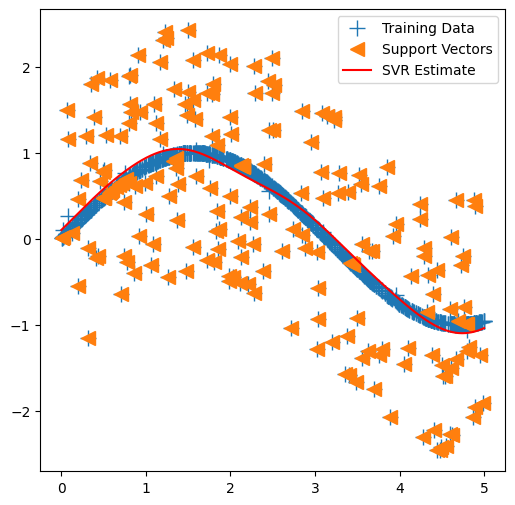

In [6]:
#<SOL>

SVR_model = SVR(kernel='rbf',C=1e0,gamma=1,epsilon=0.1)

t0 = time.time()

SVR_model.fit(X,y)

train_time = time.time()-t0

t0 = time.time()

y_plot_SVR = SVR_model.predict(X_plot)

test_time=time.time()-t0

print('Train Kernel Ridge: %f seconds' %(train_time))

print('Test Kernel Ridge: %f seconds' %(test_time))

plt.figure()
plt.plot(X,y,'+',markersize=12)
plt.plot(X[SVR_model.support_],y[SVR_model.support_],'<',markersize=10)
plt.plot(X_plot,y_plot_SVR,'r')



plt.legend(['Training Data','Support Vectors','SVR Estimate',])

print('The fraction of training points that participate in the test decision is %f ' %(100*SVR_model.support_.shape[0]/X.shape[0]))
#</SOL>

### Exercise 2
Try to vary the $\epsilon$ and $C$ values and answer the following questions:

* How can we control the tradeoff between accuracy and sparsity?
* How can we control the overfitting?

### Solution

Train Kernel Ridge: 0.001728 seconds
Test Kernel Ridge: 0.006481 seconds
The fraction of training points that participate in the test decision is 0.000000


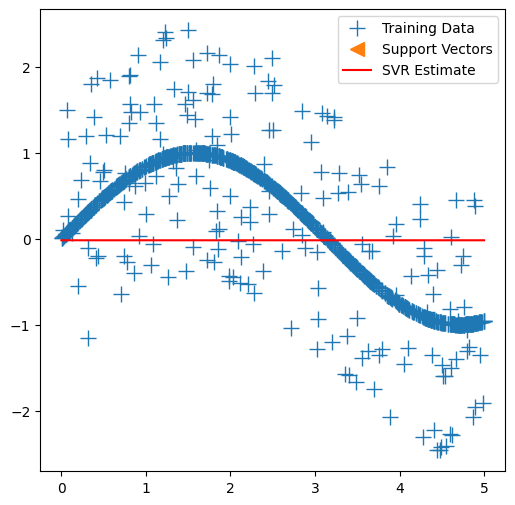

In [11]:
#<SOL>

SVR_model = SVR(kernel='rbf',C=1e0,gamma=1,epsilon=5) # Increase eps value

t0 = time.time()

SVR_model.fit(X,y)

train_time = time.time()-t0

t0 = time.time()

y_plot_SVR = SVR_model.predict(X_plot)

test_time=time.time()-t0

print('Train Kernel Ridge: %f seconds' %(train_time))

print('Test Kernel Ridge: %f seconds' %(test_time))

plt.figure()
plt.plot(X,y,'+',markersize=12)
plt.plot(X[SVR_model.support_],y[SVR_model.support_],'<',markersize=10)
plt.plot(X_plot,y_plot_SVR,'r')



plt.legend(['Training Data','Support Vectors','SVR Estimate',])

print('The fraction of training points that participate in the test decision is %f' %(100*SVR_model.support_.shape[0]/N_train))
#</SOL>